# 🤖 Notebook: Machine Learning Modeling

This notebook trains machine learning models to predict ride demand for Capital Bikeshare stations.

## ✅ Goals:
- Load processed dataset with distance-based features
- Define target and features
- Train/test split
- Train machine learning models
- Evaluate model performance
- Analyze feature importance


In [18]:
# Importing necessary libraries 
# 📚 Data Science Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 📦 Standard Library
import sys
from pathlib import Path

# 📊 Data Analysis 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🛠️ Project-Specific Modules
sys.path.append(str(Path().resolve().parent / "src"))

from paths import  INTERIM_DIR, PROCESSED_DIR, IMAGES_DIR
from helpers_folium import load_geojson_as_gdf, load_bikeshare_data, create_centered_map

## Prepare the data

In [2]:
# load Prince George's County station features
pg_station_features = pd.read_parquet(INTERIM_DIR / "station_features_2021_to_2024.parquet")

# load Prince George's County df
pg_df = pd.read_parquet(PROCESSED_DIR / "prince_george.parquet")

In [3]:
# adjusting the started_at column to datetime format
pg_df["date"] = pd.to_datetime(pg_df["started_at"],format="ISO8601").dt.date
pg_df["month"] = pd.to_datetime(pg_df["started_at"],format="ISO8601").dt.month
pg_df["year"] = pd.to_datetime(pg_df["started_at"],format="ISO8601").dt.year
pg_df["dow"] = pd.to_datetime(pg_df["started_at"],format="ISO8601").dt.day_of_week


# Grouping by Station and Week


In [4]:
pg_df["started_at"] = pd.to_datetime(pg_df["started_at"],format="ISO8601")

In [5]:
pg_df["year_week"] = pg_df["started_at"].dt.strftime("%Y-%U")

In [6]:
# Group by station and week, counting rides per group
weekly_rides = pg_df.groupby(["start_station_name", "year_week"], observed=False).agg(
    avg_rides=("member_casual", "count")  # Counting total rides per station per week./ Using a random column to check amount of rides
).reset_index()

In [7]:
pg_df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,...,WARD,NAME_left,COUNTY,area,NAME_right,Population_Density,date,month,dow,year_week
0,electric_bike,2022-01-01 01:14:29,2022-01-01 01:18:46,Capitol Heights Metro,NaN,member,38.888528,-76.913045,38.880000,-76.920000,...,NaN,NaN,Prince George's,Maryland,TOWN OF CAPITOL HEIGHTS,2250,2022-01-01,1,5,2022-00
1,classic_bike,2022-01-01 06:27:29,2022-01-01 06:50:59,Chillum Rd & Riggs Rd / Riggs Plaza,The Mall at Prince Georges,member,38.961737,-76.995922,38.968842,-76.954171,...,NaN,NaN,Prince George's,Maryland,CHILLUM,4358,2022-01-01,1,5,2022-00
2,electric_bike,2022-01-01 08:08:08,2022-01-01 08:14:01,Baltimore Ave & Jefferson St,NaN,casual,38.955485,-76.940117,38.970000,-76.940000,...,NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2571,2022-01-01,1,5,2022-00
3,classic_bike,2022-01-01 09:51:55,2022-01-01 10:18:21,The Mall at Prince Georges,Chillum Rd & Riggs Rd / Riggs Plaza,member,38.968842,-76.954171,38.961737,-76.995922,...,NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2571,2022-01-01,1,5,2022-00
4,electric_bike,2022-01-01 10:28:21,2022-01-01 10:33:19,NaN,Prince George's Plaza Metro,casual,38.960000,-76.950000,38.965742,-76.954803,...,NaN,NaN,Prince George's,Maryland,CITY OF HYATTSVILLE,2571,2022-01-01,1,5,2022-00


In [8]:
# Merge station features with grouped weekly rides
final_df = weekly_rides.merge(pg_station_features, on="start_station_name", how="left")

# RANDOM FOREST FOR WEEKLY RIDES (based on 2021-2024)

In [9]:
# Split 'year_week' into numeric 'year' and 'week' columns
final_df["year"] = final_df["year_week"].apply(lambda x: int(x.split("-")[0]))
final_df["week"] = final_df["year_week"].apply(lambda x: int(x.split("-")[1]))

# Drop the original 'year_week' column
final_df.drop(columns=["year_week"], inplace=True)

In [10]:
final_df.head()

,start_station_name,avg_rides,avg_distance_nearest_station_km,distance_to_metro_km,distance_to_poi_km,distance_to_cc_km,pop_density,year,week
0,10th & Monroe St NE,0,NaN,NaN,NaN,NaN,NaN,2022,0
1,10th & Monroe St NE,0,NaN,NaN,NaN,NaN,NaN,2022,1
2,10th & Monroe St NE,0,NaN,NaN,NaN,NaN,NaN,2022,2
3,10th & Monroe St NE,0,NaN,NaN,NaN,NaN,NaN,2022,3
4,10th & Monroe St NE,0,NaN,NaN,NaN,NaN,NaN,2022,4


In [11]:
# Defining features (X) and target (y)
X = final_df[["avg_distance_nearest_station_km", "distance_to_metro_km", "distance_to_poi_km","year","week","distance_to_cc_km","pop_density"]]
y = final_df ["avg_rides"]
#train test/split


# Extract station names before splitting
station_names = final_df["start_station_name"]

#REVIEW - # Split data into train and test. retrieving stations names with with station_test
X_train, X_test, y_train, y_test, station_train, station_test = train_test_split(
    X, y, station_names, test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 1.258636524196397
R² Score: 0.9143339447671562


In [12]:
# interpreting MAE

print("Mean Weekly Rides:", y.mean())
print("Standard Deviation of weekly Rides:", y.std())

Mean Weekly Rides: 4.766659600028267
Standard Deviation of weekly Rides: 12.781378653440932


Interpreting MAE

- If MAE is much smaller than the mean, your model is relatively accurate.
- If MAE is close to or larger than the mean, predictions may not be reliable.

Example Interpretation:

- If Mean Daily Rides = 10, but MAE = 2, this means your predictions are on average 2 rides off, which is good (~20% error).
- If Mean Daily Rides = 5, and MAE = 2, that’s a high error (~40%).

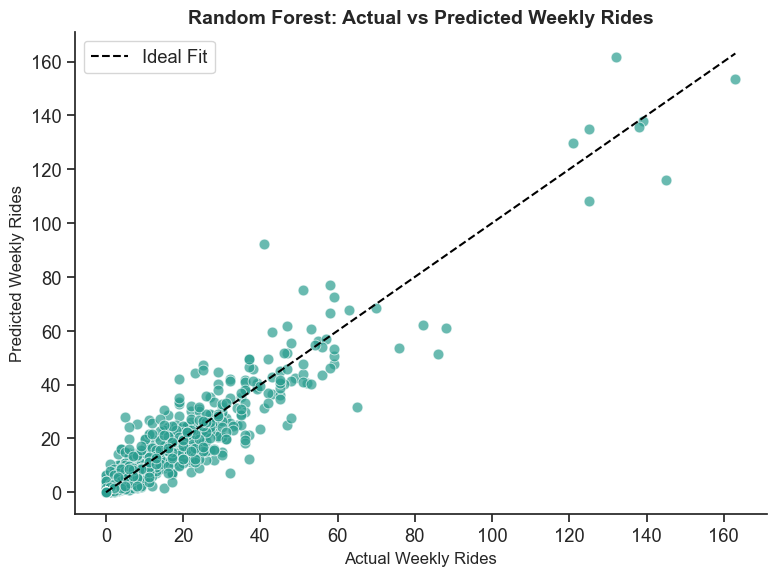

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



# Create a DataFrame for seaborn
df = pd.DataFrame({
    "Actual Weekly Rides": y_test,
    "Predicted Weekly Rides": y_pred
})

# Plot using seaborn
sns.set_theme(style="ticks", font_scale=1.2)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="Actual Weekly Rides",
    y="Predicted Weekly Rides",
    data=df,
    color="#2a9d8f",
    s=60,
    alpha=0.7
)

# Add a diagonal ideal fit line
max_val = max(df["Actual Weekly Rides"].max(), df["Predicted Weekly Rides"].max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1.5, label="Ideal Fit")

# Styling
plt.title("Random Forest: Actual vs Predicted Weekly Rides", fontsize=14, weight='bold')
plt.xlabel("Actual Weekly Rides", fontsize=12)
plt.ylabel("Predicted Weekly Rides", fontsize=12)
sns.despine()
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(IMAGES_DIR/ "actual_vs_predicted_rides.png")
plt.show()


In [22]:
# download df as csv
df.to_csv(PROCESSED_DIR / "predicted_weekly_rides.csv", index=False)

# reduce the csv to 1000 rows
df_sample = df.sample(n=1000, random_state=42)

# save the sample df as csv
df_sample.to_csv(PROCESSED_DIR / "predicted_weekly_rides_sample.csv", index=False)

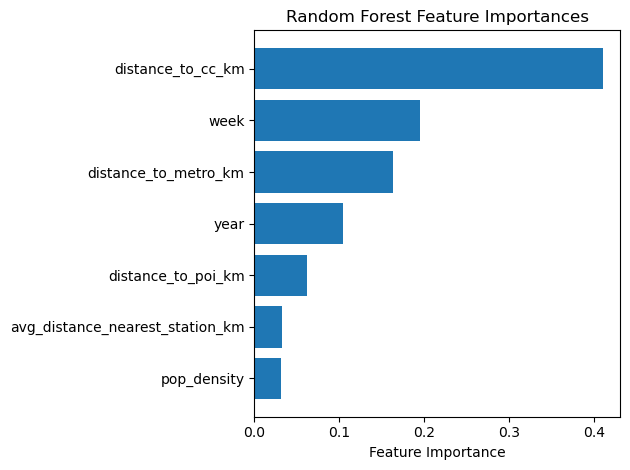

In [ ]:
# feature importances

feature_importances = model.feature_importances_
features = X.columns

sorted_idx = np.argsort(feature_importances)
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()
